# Colormaps

This Jupyter Notebook describes the rationale for developing the `ehtplot.color` submodule in `ehtplot`.  Before we get into the actual content, let's customize Jupyter so this notebook is easier to read and use.

In [2]:
from IPython.core.display import display, HTML, Javascript 

# Display text with 16px fonts
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

# Disable cell scrolling
display(Javascript("IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }"))


# Enable autoreload for easy module development
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## 0. Contents:
<a id="sec0"></a>

- [0. Contents](#sec0)
- [1. Background](#sec1)
- [2. Basic Requirements](#sec2)
- [3. Color Models and Color Spaces](#sec3)
- [4. Color Appearance Parameters](#sec4)
- [5. General Guidance](#sec5)
- [6. Colormap Inspection](#sec6)
- [7. Colormap Uniformization](#sec7)
- [8. Colormap Symmetrization](#sec8)
- [A. Appendix: List of Modified Colormaps](#secA)

## 1. Background
<a id="sec1"></a>

The [Event Horizon Telescope (EHT)](https://eventhorizontelescope.org/) is a Very-long-baseline interferometry (VLBI) experiment aiming at capture of the first pictures of black holes.  While an image worth a thousand words, the interpretation of an image is subjective.  The presentation of an image can strongly affect how human eyes identify features.  This is especially true for two-dimensional intensity maps, where the value of each pixel is represented by a color.  A poorly chosen colormap between values and colors can fool the human eyes to, e.g., pick out non-existing features, or to hide important features.

In order to present the resulting images of the EHT as accurate as possible, we take into account how human eyes work and provide a few guidance on the colormap usages in different situations.

## 2. Basic Requirements
<a id="sec2"></a>

Without putting in too much details, a good colormap for scientific representation of a scalar image should:

1. give readers a correct sense on the scalar values (intensities) in the image;

2. not artificially show features that do not exist;

3. not intentionally hide features that exist;

4. be effective in communicating scientific messages;

5. be device-independent.

We summarize some works on human visual perceptual and standards created by the [International Commission on Illumination (ICE)](https://en.wikipedia.org/wiki/International_Commission_on_Illumination) below.  We will then use these basic knowledge to derive general guidance on deriving and using colormaps.

## 3. Color Models and Color Spaces
<a id="sec3"></a>

The "raw" [RGB](https://en.wikipedia.org/wiki/RGB_color_model) and [CMYK](https://en.wikipedia.org/wiki/CMYK_color_model) [color models](https://en.wikipedia.org/wiki/Color_model) are device-dependent.  In order to describe device-independent color, companies create "standardized" [color spaces](https://en.wikipedia.org/wiki/Color_space) such as [sRGB](https://en.wikipedia.org/wiki/SRGB) (standard RGB by HP and Microsoft) and [Adobe RGB](https://en.wikipedia.org/wiki/Adobe_RGB_color_space). A [color profile](https://en.wikipedia.org/wiki/ICC_profile), either characterizes a device or a color space, can then be used to accurately map the color in an image to a device.

The [CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space) (also CIE L\*a\*b\*, hereafter Lab) color space, introduced by the CIE in 1976, was the first attempt to take into account the the perceptual aspects of human vision.  Here, L\* is the lightness; a\* and b\* are the green-red and blue-yellow color components.  The [CIECAM02](https://en.wikipedia.org/wiki/CIECAM02) [color appearance model (CAM)](https://en.wikipedia.org/wiki/Color_appearance_model) published by the CIE in 2002 defines six color appearances: brightness Q, lightness J, colorfulness M, chroma C, saturation s, and hue h.  And the [iCAM06](https://en.wikipedia.org/wiki/Color_appearance_model#iCAM06) model is capable of handling spatial appearance phenomena such as contrast.

In 2006, [Luo et al.](https://www.researchgate.net/publication/229879898_Uniform_colour_spaces_based_on_CIECAMO2_colour_appearance_model) introduced three modifications to CIECAM02 to make it more uniform.  The CAM02-UCS, stands for "Uniform Colour Space", is not popular in computer graphics.  Its three coordinates are usually denoted by J', a', and b'.  And its cylindrical coordinates are J', C', and h'.

It is useful to transform the Cartesian Lab and CIECAM02 color spaces to the cylindrical [CIELCh](https://en.wikipedia.org/wiki/CIELAB_color_space#Cylindrical_representation:_CIELCh_or_CIEHLC) (hereafter LCh) and CIEJCh (hereafter JCh) color spaces which has coordinates L\*, J\*, C\*, and h. The lightness coordinates L\* and J\* are identical to Lab and Jab.  The chroma (relative saturation) C\* and hue h (in degree h°) are simply `C* = sqrt(a*^2 + b*^2)` and `h = atan2(b*, a*)` according to Redness-Greenness a and Yellowness-Blueness b in their own coordinates.

## 4. Color Appearance Parameters
<a id="sec4"></a>

We ignore spatial appearance phenomena and consider only the the six color appearance parameters defined by CIECAM02.  They can be grouped into three classes, correspond to the three coordinates of LCh:

- [Brightness](https://en.wikipedia.org/wiki/Brightness) and   [lightness](https://en.wikipedia.org/wiki/Lightness): they are the   extrinsic and intrinsic "tones" or "values", respectively.

- [Colorfulness](https://en.wikipedia.org/wiki/Colorfulness), [chroma](https://en.wikipedia.org/wiki/Colorfulness#Chroma_in_CIE_1976_L*a*b*_and_L*u*v*_color_spaces), and [saturation](https://en.wikipedia.org/wiki/Colorfulness#Saturation): colorfulness and chroma are, roughly speaking, the extrinsic and intrinsic difference between a color and gray of an object, respectively.  Saturation is the colorfulness of a color relative to its own brightness.

- [Hue](https://en.wikipedia.org/wiki/Hue): "the degree to which a stimulus can be described as similar to or different from stimuli that are described as red, green, blue, and yellow."  Note that the CIELCh hue and (s)RGB hue `h_rgb = atan2(sqrt(3) * (G-B), 2*R - G - B)` are not equivalent.

It is important to note that the above terms can be defined very differently in different context.  For example, RGB brightness is defined as `(R + G + B) / 3`, which is completely different than CIECAM02 brightness.

## 5. General Guidance
<a id="sec5"></a>

In response to the above requirements, at minimal,

- we need to use *perceptually uniform colormaps*

so that the lightness of the color in an image is a fair representation of its scalar values.  While visual perception is a complex science, the CAM02-UCS lightness J' should serve us as a good approximation for generating perceptually uniform colormaps.  In fact, linearity in J' is used as the working definition of Perceptually Uniform Sequential colormaps by [matplotlib](https://matplotlib.org/users/colormaps.html).

Since chrominance is a two-dimensional quantity, we can use the different dimensions for different purposes.  Being independent of lightness and chroma and easily recognized,

- *hue h' can encode an additional physical quantity* in an image (when used in this way, the change of hue should be linearly proportional to the quantity);

- *hue h' is also ideal in making an image more attractive* without interferencing the representation of pixel values.

The other dimension chroma is less recognizable and should not be used to encode physical information.  Since sRGB is only a subset of the Lab color space, there are human recognizable color that are not displayable.  In order to accurately represent the physical quantities,

- if a color is not displayable, one should preserve its lightness J' and hue h', and adjust its chroma C'.

- *saturation s' is also useful to place focus of an image* without affecting the representation of the physical quantities.

Given that human eyes are less sensitive to color in low light,

- if color is used to encode an additional physical quantity in a figure, the *colormap may start (or end) at non-zero lightness*.

Finally, sRGB is often the default image color space for modern softwares.  That is, if we save an image without a color profile, it is often interpreted as in sRGB with [gamma](https://en.wikipedia.org/wiki/Gamma_correction) 2.2.  Therefore, we should

- convert colormaps to sRGB with gamma 2.2, and then save the resulting images without any color profile.

## 6. Colormap Inspection
<a id="sec6"></a>

With all the above discussion, we are finally at a point to look into colormaps.  Let's first load up matplotlib and find out what colormaps are available:

In [3]:
import matplotlib.pyplot as plt

colormaps = plt.colormaps()

print(", ".join(colormaps))
print("{} colormaps in total".format(len(colormaps)))

Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2,

There are 164 built-in colormaps.  Most of them are actually not perceptually uniform.  To check this, let's define a plotting function with helps from `ehtplot.color.vis`

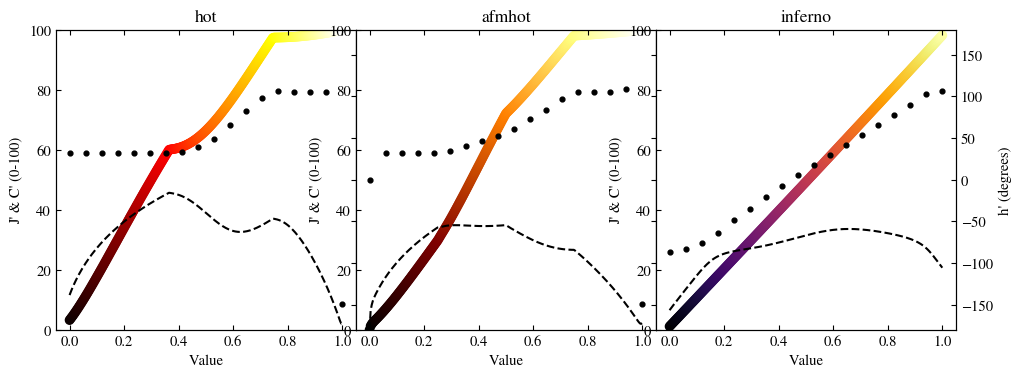

In [4]:
import ehtplot as eht

fig = eht.plot(cmap=['hot', 'afmhot', 'inferno'], figsize=(9, 3))
fig.draw()

Here, we look at three popular warm colormaps: `hot`, `afmhot`, and `inferno`.  The thick colorful curves are the lightness J', the black dashed lines are the chroma C', and the black dots are the hue h'.

It is clear that the popular `hot` and `afmhot` colormaps are not J'-linear, while `interno` is.  It is interesting that both `hot` and `afmhot` are almost linear in the low J' regime, and become flat in the high J' regime---we will have a discuss about this in the next section.  The colormaps' peak chroma decreases from `hot`, to `afmhot`, and `inferno`.  In layperson's term, this means that `hot` is the "sharpest" or "brightest" colormap, while `inferno` is the "flattest".  Finally, according to the hue curve, none of above colormaps is in a single color---they actually transit from red (for `hot` and `afmhot`) or blue (for `inferno`) to yellow in different ways.  Also, the `hot` chroma curve is very uneven and not even bi-tonic.  It saturates at red and yellow.  The `afmhot` chroma is at least bi-tonic.  And the `inferno` colormap's chroma is both smooth and bi-tonic.

To demonstrate how non-uniform colormaps can lead to faulty feature extraction, we create a pyramid function and plot it with different colormaps.  In the ideal situation, our eyes should only pick out the corners in the pyramid.  That is, we should pick out a cross "X" in the image, in addition to the color gradient.

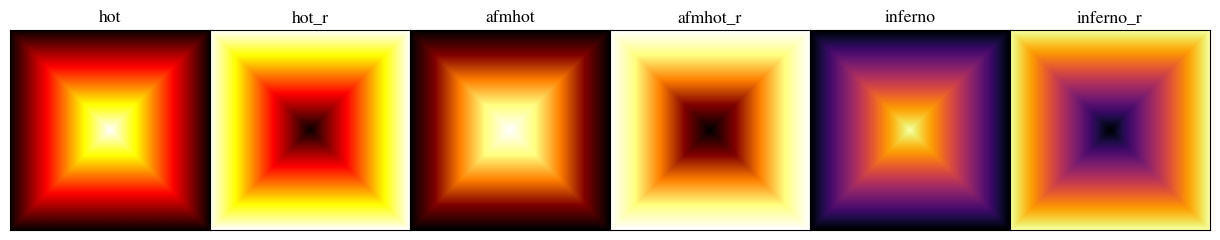

In [5]:
cmaps = ['hot', 'hot_r', 'afmhot', 'afmhot_r', 'inferno', 'inferno_r']
fig = eht.plot(cmap=cmaps, type='pyramid', figsize=(12, 2))
fig.draw()

The above figure shows the visualization using matplotlib's built-in colormaps.  For `hot` and `hot_r`, we artificially see red and yellow squares in them.  If we go back to the J'(v) plots, we can identical these squares come from features in J'.  These artifacts are much weaker in `afmhot` and `afmhot_r`, although we can still see a yellow, orange, and brown squares them, which correspond to the features in their J' curves.  Being J'-linear, the square artifacts are weakest in `inferno` and `inferno_r`, although it is still possible to identify orange and purple squares because of the color transitions.

To see how good/bad these colormaps are, let's load up some components of a Principal Component Analysis (PCA) of a numerical simulation of a black hole (see [Medeiros et al. 2018](http://adsabs.harvard.edu/abs/2018ApJ...864....7M)) and plot them in the `inferno`, `hot`, and `afmhot` colormaps.

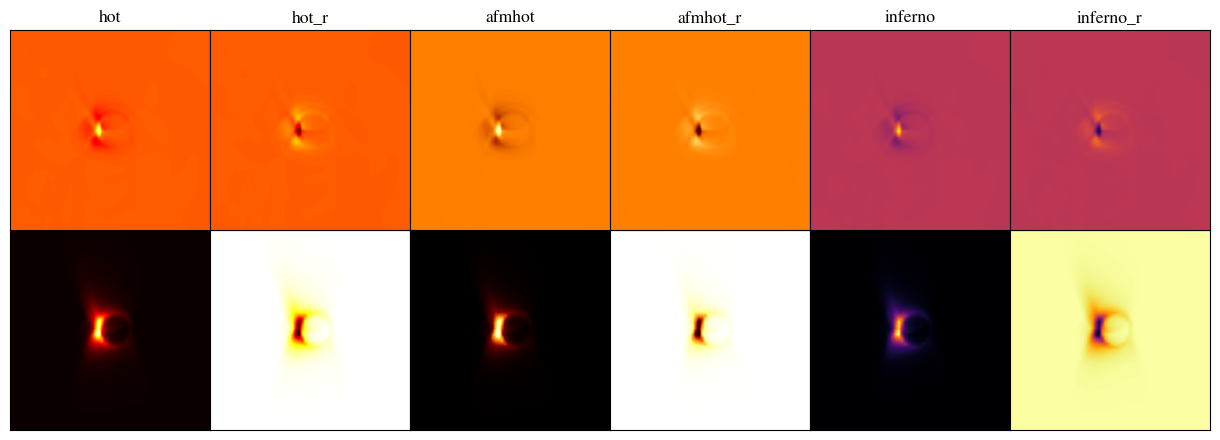

In [6]:
import numpy as np
from ehtplot.extra import io

pca0 = io.open("examples/sample", component="pca0")
pca1 = io.open("examples/sample", component="pca1")

def plotimg(ax, img, *cmap, label=None):
    cmap = ''.join(cmap)

    vmax = np.max(img)
    vmin = np.min(img)
    if vmin >= 0.0:
        vmin = 0.0
    else:
        vmin = -max(vmax, -vmin)

    ax.imshow(img, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title(cmap)

fig = eht.plot(plotimg, [pca0, pca1], [cmaps], title=['PCA0, PCA1'], figsize=(12,4))
fig.draw()

The panels above plot the same images (0th PCA component in top row, 1st PCA component in bottom row) in `hot`, `hot_r`, `afmhot`, `afmhot_r`, `inferno`, and `inferno_r`.  The `_r` postfixed colormaps are simply reversed of their non-`_r` counter parts.

Although the accretion funnel, shown in light yellow in `hot_r` and `afmhot_r`, is difficult to see in both `hot`, `afmhot`, it is still more visible in the `_r` colormaps than non-`_r` colormaps.  Similar effect is also seen in `inferno_r` and `infreno`, where we can identify the brown funnel in `inferno_r` but difficult to pick out the very dark funnel in `inferno`.  This is indeed a consequence of our eyes being less sensitive to color in dim light.

## 7. Colormap Uniformization
<a id="sec7"></a>

As demostrated by the pyramid function above, non-uniformality in lightness is the main reason of faulty feature extractions from image.  To correct for this, we implement a colormap uniformization algorithm in `ehtplot` to redistribute colors in a colormap.  The resulting colormap is J'-linear and it contains only color in the original colormap.

Actually, whenever `ehtplot` is loaded, there are 364 new colormaps automatically made available to `matplotlib`.

In [7]:
colormaps = plt.colormaps()
print("{} colormaps in total".format(len(colormaps)))

673 colormaps in total


The colormap loading mechaism is intentionally designed that it needs only `numpy` and `matplotlib`.  Even if a user doesn't need the plotting features in `ehtplot`, they can still use its colormaps without installing additional python module.
 
Among the 182 new colormaps, 90 of them are uniformized versions of matplotlib's built-in colormaps.  They are postfixed with `_u`.  Note that matplotlib's built-in uniform colormaps `viridis`, `plasma`, `inferno`, `magma`, and `cividis` are not linearized.

Here, we plot the uniformized `hot_u` and `afmhot_u` with `inferno`:

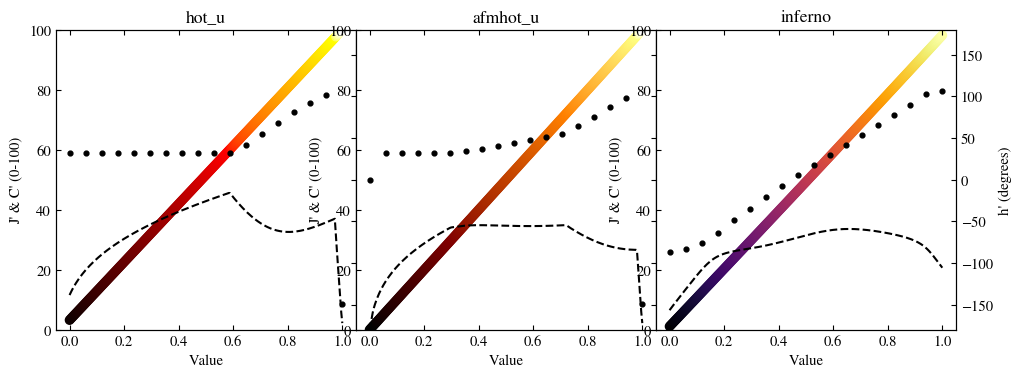

In [8]:
fig = eht.plot('cmap', ['hot_u', 'afmhot_u', 'inferno'], figsize=(9, 3))
fig.draw()

Now we can replot the pyramid and see why the uniform colormaps are better than their non-uniform counterparts.  The top row is the same as above.  The bottom row shows the pyramid function using `ehtplot`'s uniformized colormaps, while `inferno` and `inferno_r` remain the same.

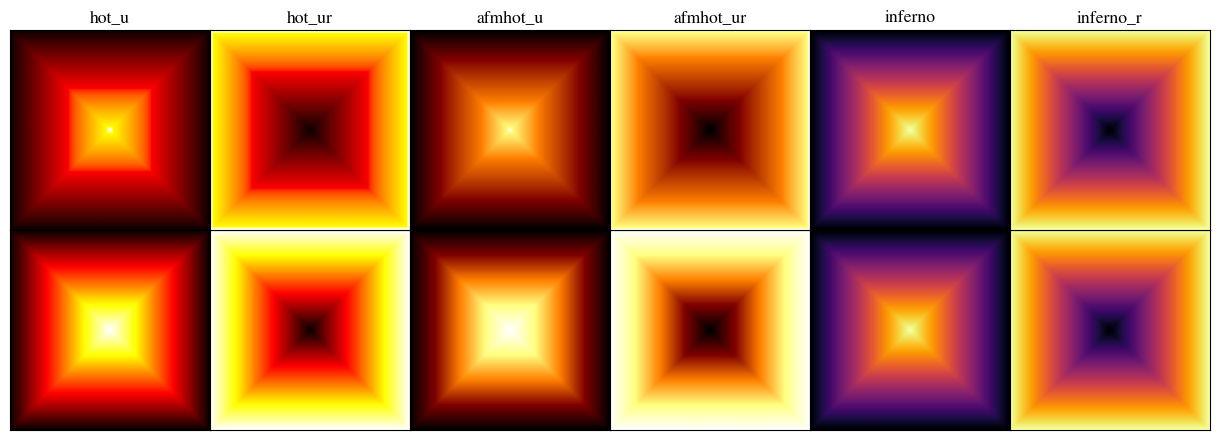

In [9]:
cmaps_u = ['hot_u', 'hot_ur', 'afmhot_u', 'afmhot_ur', 'inferno', 'inferno_r']
fig = eht.plot('cmap', [cmaps, cmaps_u], type='pyramid', title=['Original', 'Uniformized (with "_u" postfix)'], figsize=(12, 4))
fig.draw()

Although some artifacts can still be identified in `hot` and `hot_r` because of the peaks in the chroma C' curve, they are much weaker (hence good) compare to the top row.  In fact, the uniformized `afmhot_u` map `afmhot_ur` shows almost no artifactial square feature, which is in some sense even better than `inferno`.

We can perform similar comparison for black hole images.

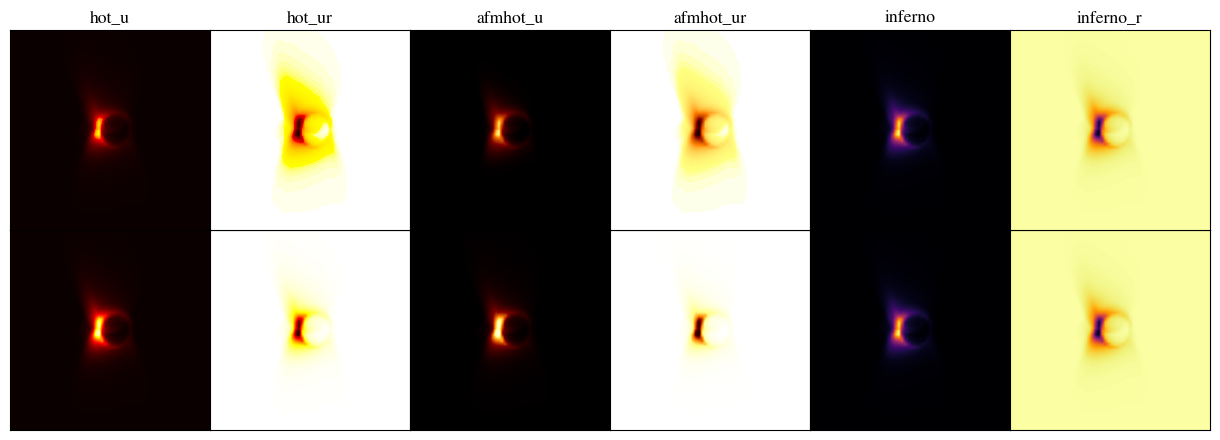

In [10]:
fig = eht.plot(plotimg, pca0, [cmaps, cmaps_u], title=['Original', 'Uniformized (with "_u" postfix)'], figsize=(12,4))
fig.draw()

Comparing `hot_r` and `afmhot_r` with the uniformized `hot_ur` and `afmhot_ur`, in the high lightness regime, a lot more features (funnel) of the image are now visible.  Comparing `hot_u` with `hot_ur` or `afmhot_u` with `afmhot_ur` indications that the same features are not visible in `hot` and `afmhot`.  This "asymmetry" between low and high lightness suggests that linear in J' is not enough to provide a subjective representation of an image.  In fact, the images are more "symmetric" in `hot`-`hot_r` and `afmhot`-`afmhot_r`.  This is an interesting observation that the flatten top of the `hot` and `afmhot` colormaps actually counter acts the effect they color are less distingisble in dim light.

Since we want to keep the linearity in high J', this suggests that one way to "symmetrize" the colormaps is to lift up the lower bound of J'.  Among the colormaps `ehtplot` provides, there are number of them have numbers in their names.

In [11]:
import re

numu = re.compile(r'^.*_[0-9]+ur?$')

count = 0
for cm in colormaps:
    if numu.match(cm):
        print(cm, end=', ')
        count += 1
print("{} numbered colormaps in total".format(count))

afmhot_10u, afmhot_10ur, afmhot_20u, afmhot_20ur, afmhot_30u, afmhot_30ur, afmhot_40u, afmhot_40ur, afmhot_50u, afmhot_50ur, gist_heat_10u, gist_heat_10ur, gist_heat_20u, gist_heat_20ur, gist_heat_30u, gist_heat_30ur, gist_heat_40u, gist_heat_40ur, gist_heat_50u, gist_heat_50ur, gray_10u, gray_10ur, gray_20u, gray_20ur, gray_30u, gray_30ur, gray_40u, gray_40ur, gray_50u, gray_50ur, hot_10u, hot_10ur, hot_20u, hot_20ur, hot_30u, hot_30ur, hot_40u, hot_40ur, hot_50u, hot_50ur, 40 numbered colormaps in total


These numbers indicate the percentage level that they are "lifted" up.  We can plot these colormaps in order of how much they are lifted.  To my eyes, `afmhot_20u` makes the largest part of the funnel visible, although none of the colormap is perceptually symmetric between bright and dim.

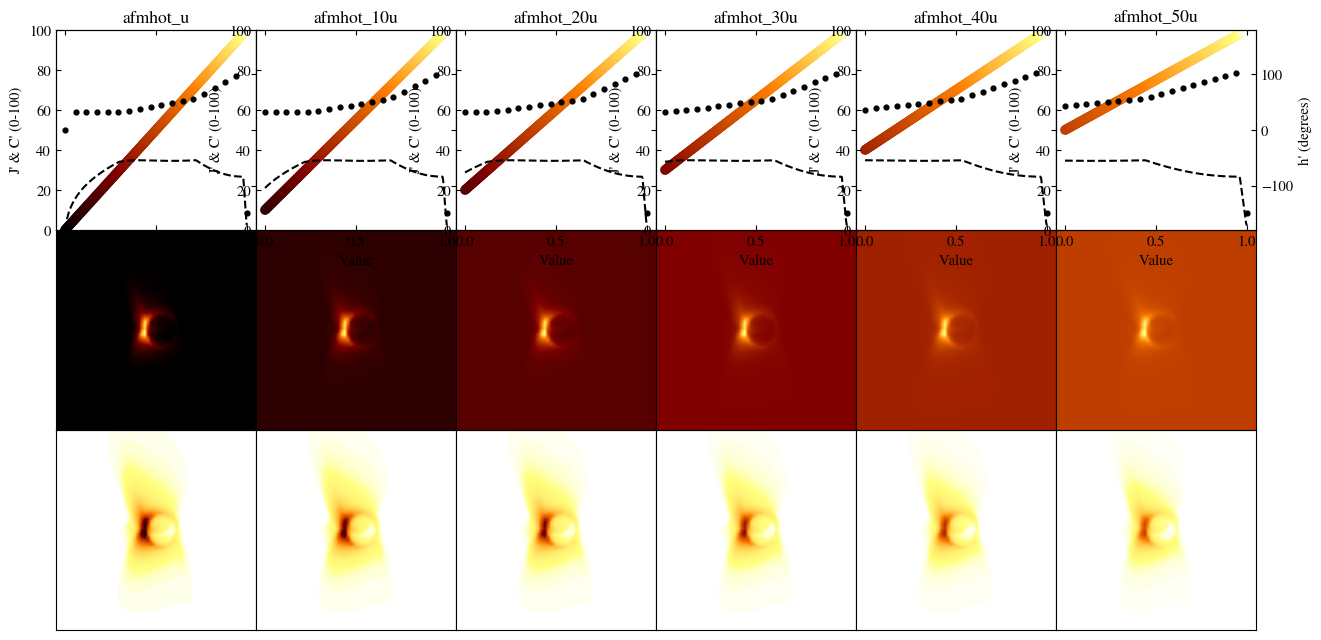

In [12]:
lifted = ['afmhot_u', 'afmhot_10u', 'afmhot_20u', 'afmhot_30u', 'afmhot_40u', 'afmhot_50u']
top = eht.panel('cmap', lifted)
mid = eht.panel(plotimg, pca0, lifted, title="Original")
bot = eht.panel(plotimg, pca0, [cm+'r' for cm in lifted], title="Reversed")
fig = eht.plot(bot, mid, top, inrow=False, figsize=(12, 6))
fig.draw()

## 8. Colormap Symmetrization
<a id="sec8"></a>

Given that lifting the lightness floor of a colormap cannot completely resolve the asymmetry between high and low lightness, we need to adjust another quality.  From the above plot, one of the most distingishable asymmetric feature is the jump in chroma C' near value 1.0.  Hence, our next natural modification to matplotlib colormap is to symmetrize chroma C'.

Because sRGB only cover part of the Lab colorspace, it we use standard mathematical symmetrization, i.e., C'' = (C' + revert(C'))/2, then large parts of the symmetrized colormap will become irrenderable.  Hence, we take the more conservative approach to use C'' = pointwisemin(C', revert(C')).  This makes most parts of the colormap renderable except very few color with high lightness and low chroma.  To address these exceptions, we introduce a softening constant and clip the color tables.

Symmetrized colormaps are postfixed with `_s`.  To see their effects, we replot the black hole image in them:

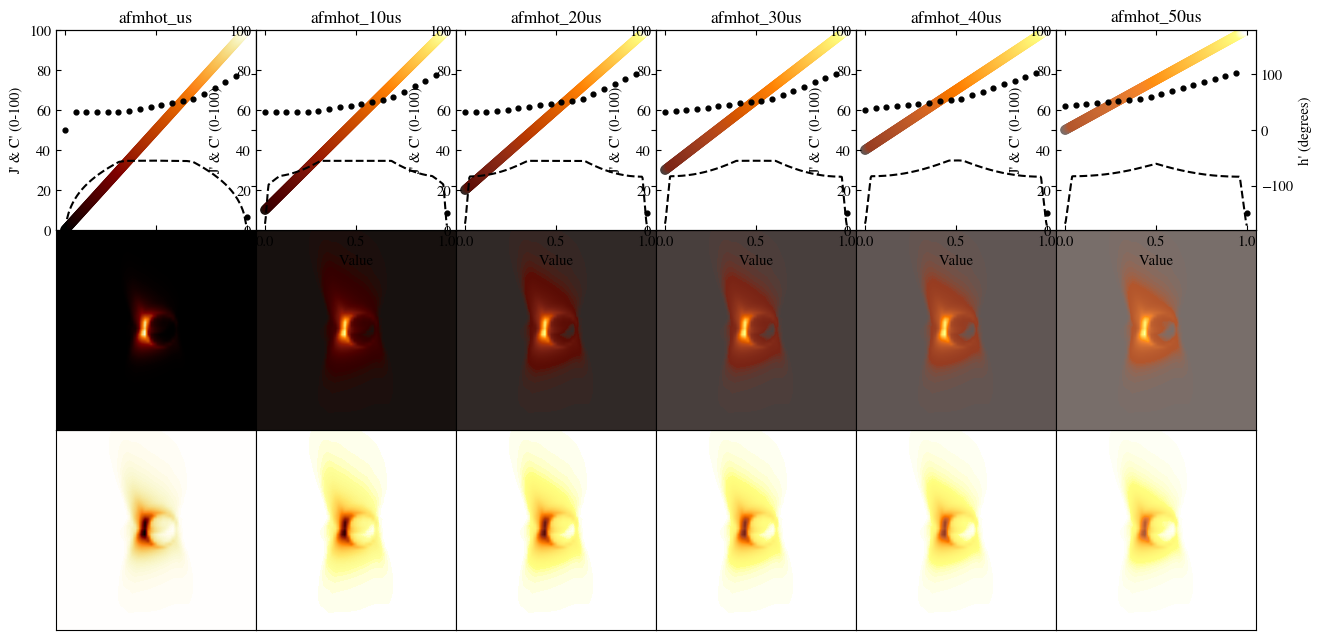

In [13]:
symmetrized = [cm+"s" for cm in lifted]
top = eht.panel('cmap', symmetrized)
mid = eht.panel(plotimg, pca0, symmetrized, title="Original")
bot = eht.panel(plotimg, pca0, [cm+'r' for cm in symmetrized], title="Reversed")
fig = eht.plot(bot, mid, top, inrow=False, figsize=(12, 6))
fig.draw()

The strong difference in chroma makes the funnel visible starting in `afmhot_10us`.

## A. Appendix: List of Modified Colormaps
<a id="secA"></a>

The colormaps made available by `ehtplot` are all modifications of `matplotlib`'s built-in colormaps.  We list all of them alongside with the original ones in this appendix:

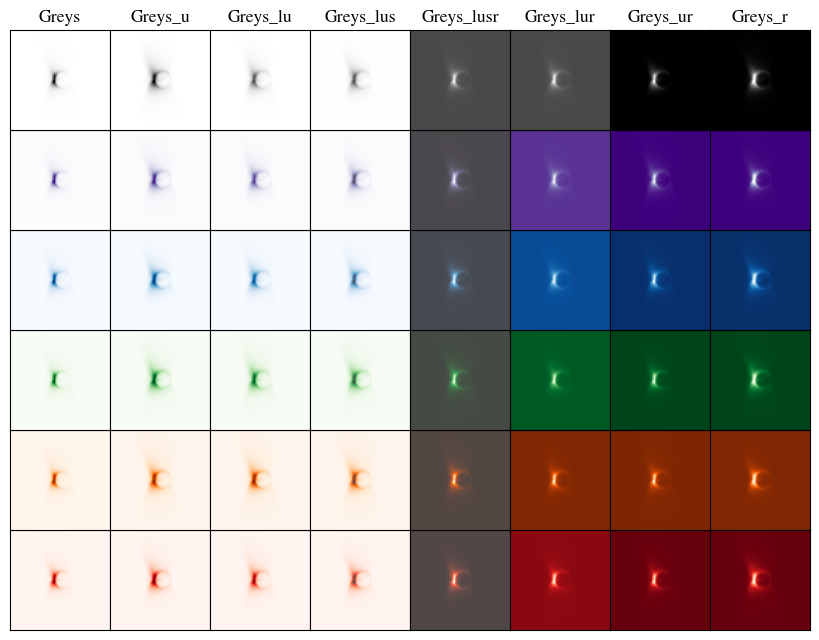

In [14]:
colormaps = list(reversed(["Greys", "Purples", "Blues", "Greens", "Oranges", "Reds"]))
postfixes = ["", "_u", "_lu", "_lus", "_lusr", "_lur", "_ur", "_r"]

fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

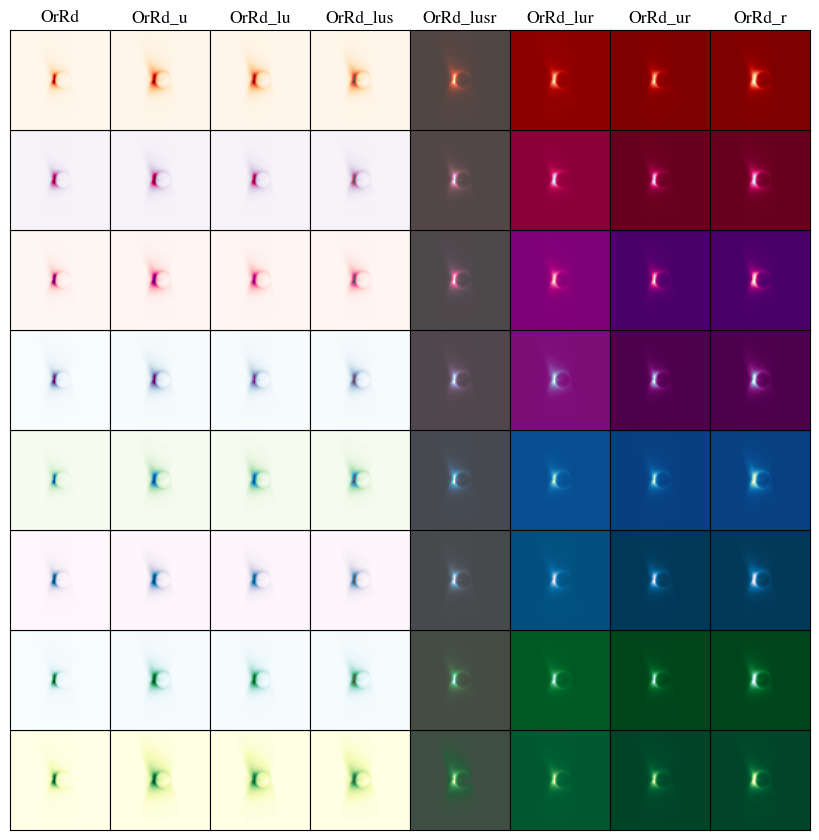

In [15]:
colormaps = list(reversed(["OrRd", "PuRd", "RdPu", "BuPu", "GnBu", "PuBu", "BuGn", "YlGn"]))
postfixes = ["", "_u", "_lu", "_lus", "_lusr", "_lur", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

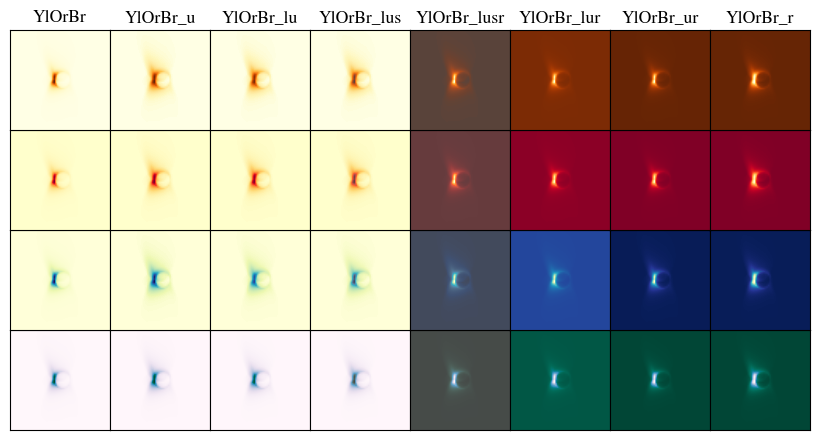

In [16]:
colormaps = list(reversed(["YlOrBr", "YlOrRd", "YlGnBu", "PuBuGn"]))
postfixes = ["", "_u", "_lu", "_lus", "_lusr", "_lur", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

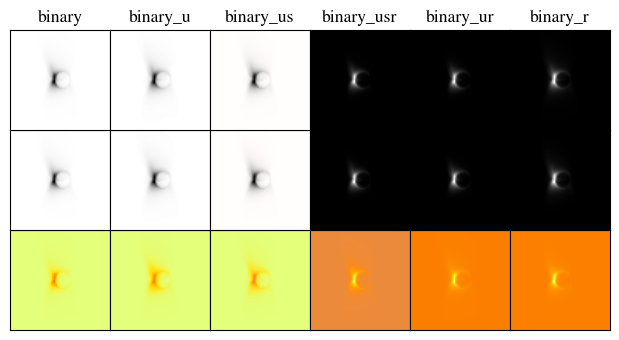

In [17]:
colormaps = list(reversed(["binary", "gist_yarg", "Wistia"]))
postfixes = ["", "_u", "_us", "_usr", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

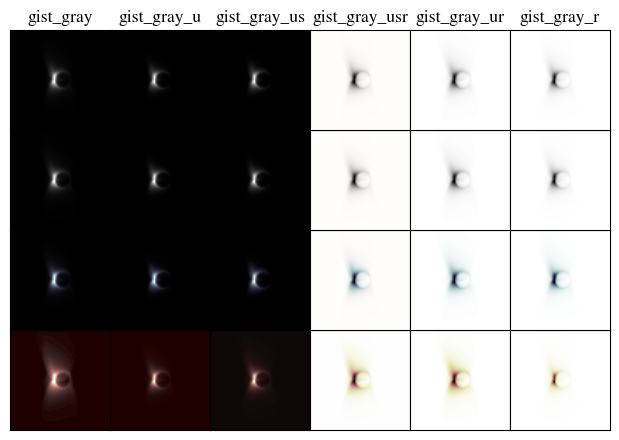

In [18]:
colormaps = list(reversed(["gist_gray", "gray", "bone", "pink"]))
postfixes = ["", "_u", "_us", "_usr", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

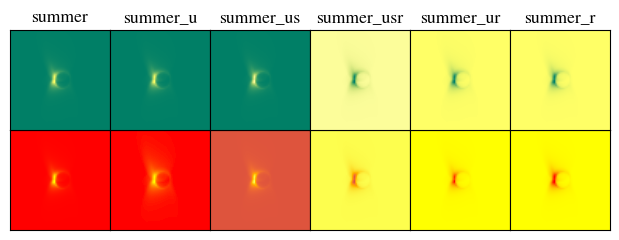

In [19]:
colormaps = list(reversed(["summer", "autumn"]))
postfixes = ["", "_u", "_us", "_usr", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

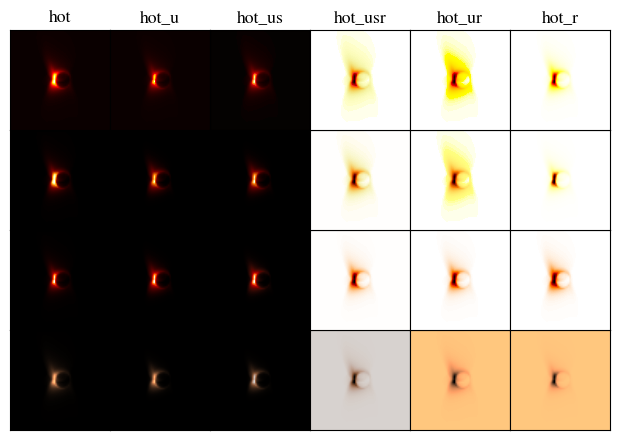

In [20]:
colormaps = list(reversed(["hot", "afmhot", "gist_heat", "copper"]))
postfixes = ["", "_u", "_us", "_usr", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

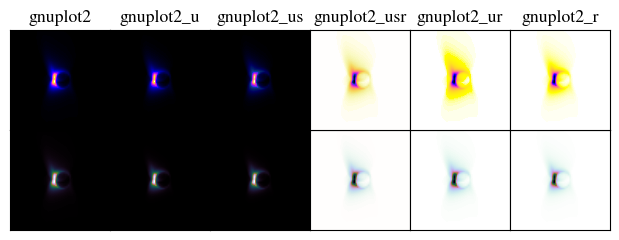

In [21]:
colormaps = list(reversed(["gnuplot2", "cubehelix"]))
postfixes = ["", "_u", "_us", "_usr", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

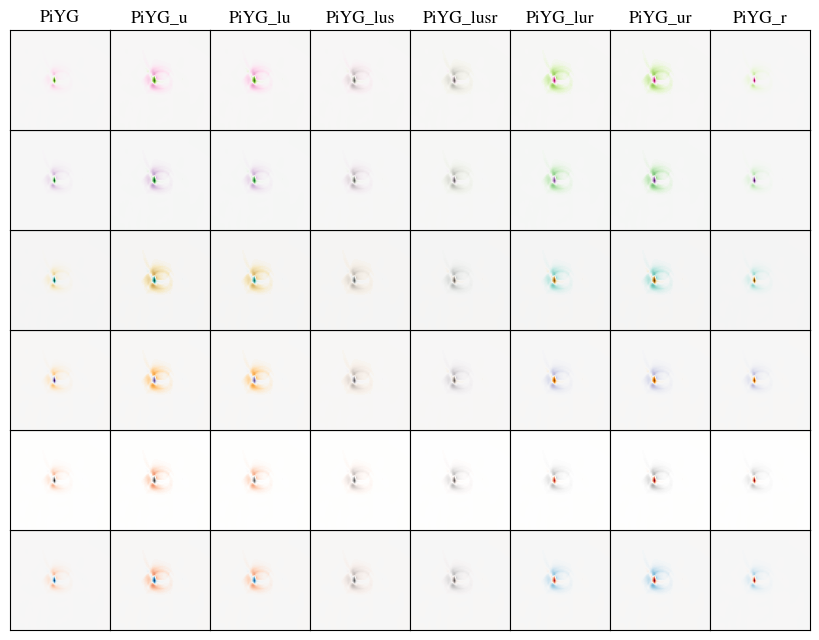

In [22]:
colormaps = list(reversed(["PiYG", "PRGn", "BrBG", "PuOr", "RdGy", "RdBu"]))
postfixes = ["", "_u", "_lu", "_lus", "_lusr", "_lur", "_ur", "_r"]
fig = eht.plot(plotimg, pca1, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

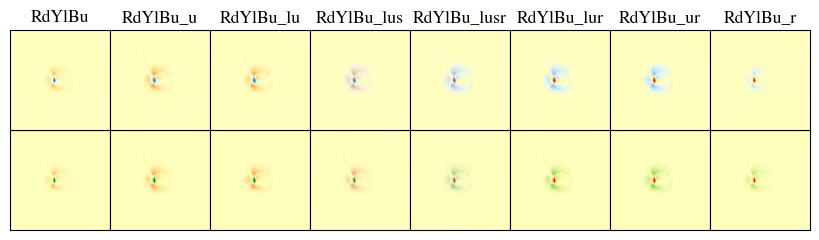

In [23]:
colormaps = list(reversed(["RdYlBu", "RdYlGn"]))
postfixes = ["", "_u", "_lu", "_lus", "_lusr", "_lur", "_ur", "_r"]
fig = eht.plot(plotimg, pca1, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

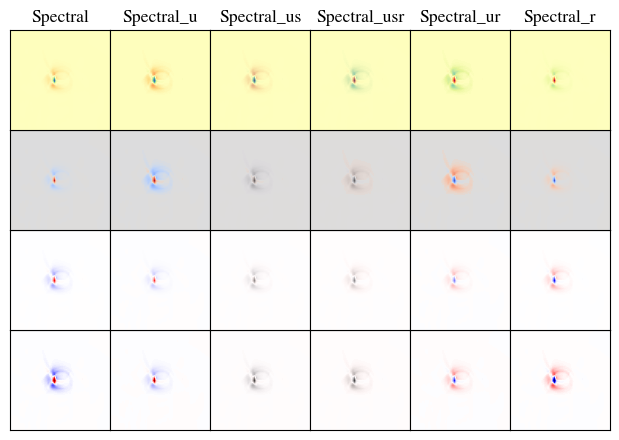

In [24]:
colormaps = list(reversed(["Spectral", "coolwarm", "bwr", "seismic"]))
postfixes = ["", "_u", "_us", "_usr", "_ur", "_r"]
fig = eht.plot(plotimg, pca1, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()

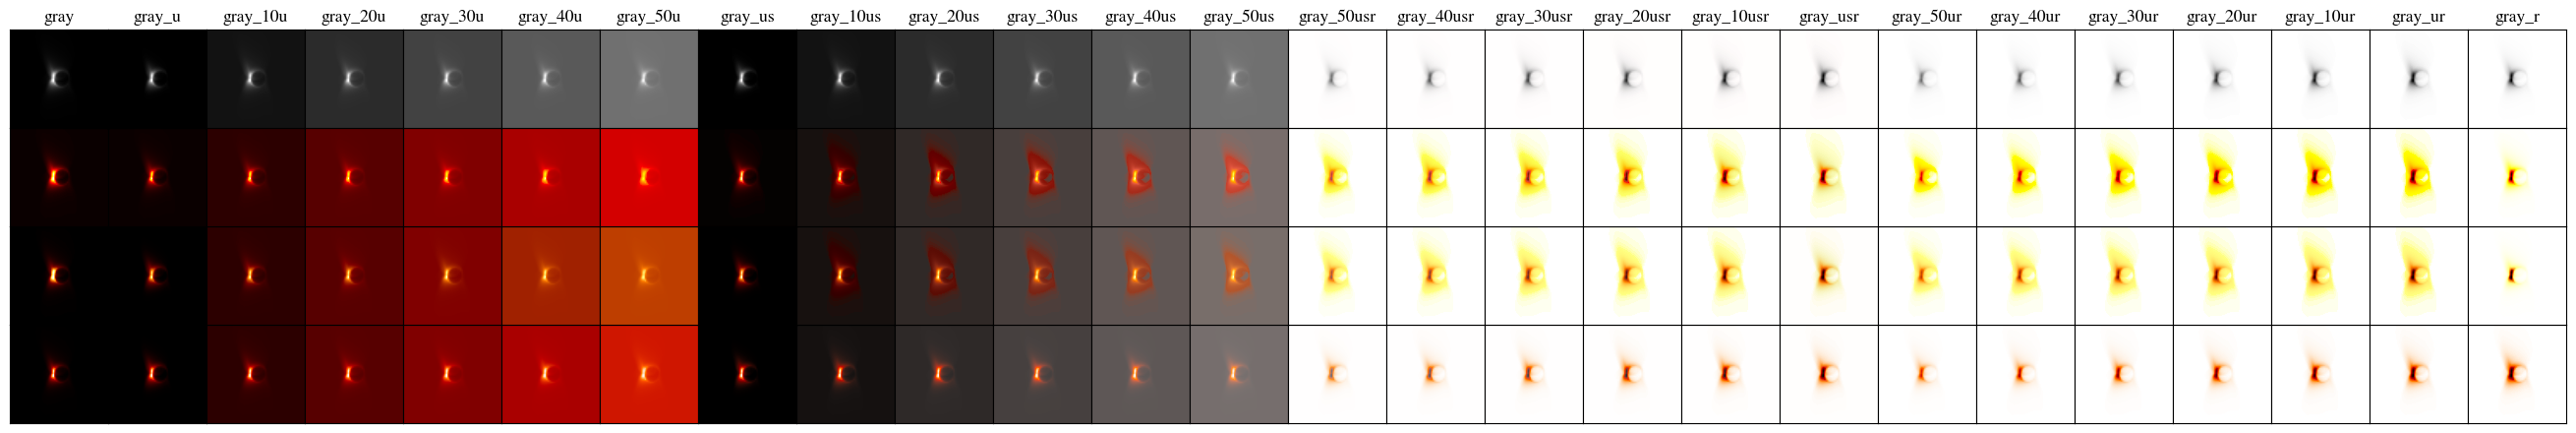

In [25]:
colormaps = list(reversed(["gray", "hot", "afmhot", "gist_heat"]))
postfixes = ["", "_u", "_10u", "_20u", "_30u", "_40u", "_50u",
             "_us", "_10us", "_20us", "_30us", "_40us", "_50us",
             "_50usr", "_40usr", "_30usr", "_20usr", "_10usr", "_usr",
             "_50ur", "_40ur", "_30ur", "_20ur", "_10ur", "_ur", "_r"]
fig = eht.plot(plotimg, pca0, colormaps, [postfixes], figsize=(len(postfixes), len(colormaps)))
fig.draw()